In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os

plots_dir = 'src/data/outputs/plots/game_theory/by_model/'

In [5]:
def count_strategy_switches(actions):
    if not actions or len(actions) < 2:
        return 0
    return sum(1 for i in range(1, len(actions)) if actions[i] != actions[i-1])

In [21]:
full_path = "src/data/outputs/by_model.csv"
df = pd.read_csv(full_path, converters={
        'agent_1_scores': lambda x: list(map(int, x.strip('[]').split(','))),
        'agent_2_scores': lambda x: list(map(int, x.strip('[]').split(','))),
        'total_rounds': int
    })

model_names = [
    "deepseek-chat", 
    "claude-3-haiku-20240307", 
    "gemini-2.0-flash-lite", 
    #"gemini-1.5-flash-002", 
    "gpt-4o-mini-2024-07-18", 
    #"gemini-2.0-flash", 
    "gemini-2.5-pro-exp-03-25", 
    "gpt-4.1-mini-2025-04-14", 
    "gpt-3.5-turbo"
]
# Filter the DataFrame to include only the specified model names
df = df[df['model_name_1'].isin(model_names) | df['model_name_2'].isin(model_names)]

#filter out models
nonmbti = ['NONE', 'ALTRUISTIC', 'SELFISH']
# Map each personality to its dichotomies
def safe_dichotomy_extraction(x, position, positive_letter, negative_letter):
    if x in nonmbti:
        return None
    else:
        return positive_letter if x[position] == positive_letter else negative_letter

# Correct parsing
df['I/E_1'] = df['personality_1'].apply(lambda x: safe_dichotomy_extraction(x, 0, 'I', 'E'))
df['N/S_1'] = df['personality_1'].apply(lambda x: safe_dichotomy_extraction(x, 1, 'N', 'S'))
df['T/F_1'] = df['personality_1'].apply(lambda x: safe_dichotomy_extraction(x, 2, 'T', 'F'))
df['J/P_1'] = df['personality_1'].apply(lambda x: safe_dichotomy_extraction(x, 3, 'J', 'P'))

df['I/E_2'] = df['personality_2'].apply(lambda x: safe_dichotomy_extraction(x, 0, 'I', 'E'))
df['N/S_2'] = df['personality_2'].apply(lambda x: safe_dichotomy_extraction(x, 1, 'N', 'S'))
df['T/F_2'] = df['personality_2'].apply(lambda x: safe_dichotomy_extraction(x, 2, 'T', 'F'))
df['J/P_2'] = df['personality_2'].apply(lambda x: safe_dichotomy_extraction(x, 3, 'J', 'P'))


df['agent_1_cumulative_scores'] = df['agent_1_scores'].apply(lambda x: [0] + list(pd.Series(x).cumsum()))
df['agent_2_cumulative_scores'] = df['agent_2_scores'].apply(lambda x: [0] + list(pd.Series(x).cumsum()))

#parse as lists, something went wrong when saving the csv
df['truthful_agent_1'] = df['truthful_agent_1'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['truthful_agent_2'] = df['truthful_agent_2'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Parse the actions as lists of strings
df['agent_1_actions'] = df['agent_1_actions'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['agent_2_actions'] = df['agent_2_actions'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['agent_1_messages'] = df['agent_1_messages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['agent_2_messages'] = df['agent_2_messages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['intent_agent_1'] = df['intent_agent_1'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['intent_agent_2'] = df['intent_agent_2'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

df['strategy_switches_agent_1'] = df['agent_1_actions'].apply(count_strategy_switches)
df['strategy_switches_agent_2'] = df['agent_2_actions'].apply(count_strategy_switches)

# Calculate the average cost per round for each row
df['cost_per_round'] = df['total_cost_USD'] / df['total_rounds']




## plot the final scores of each agent of each game

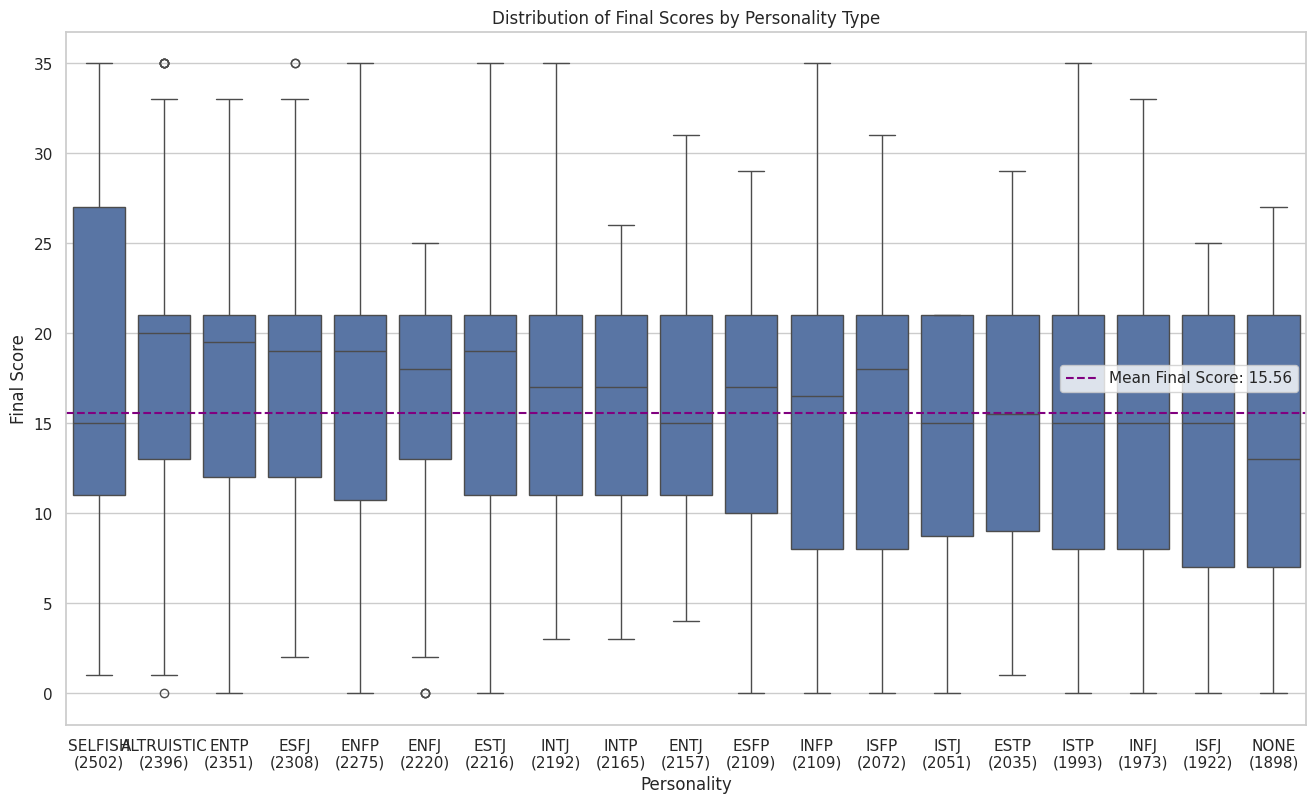

/tmp/ipykernel_2228954/2406936046.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=final_scores_df, x='Personality', y='Final Score', inner='quartile', palette='Set3')


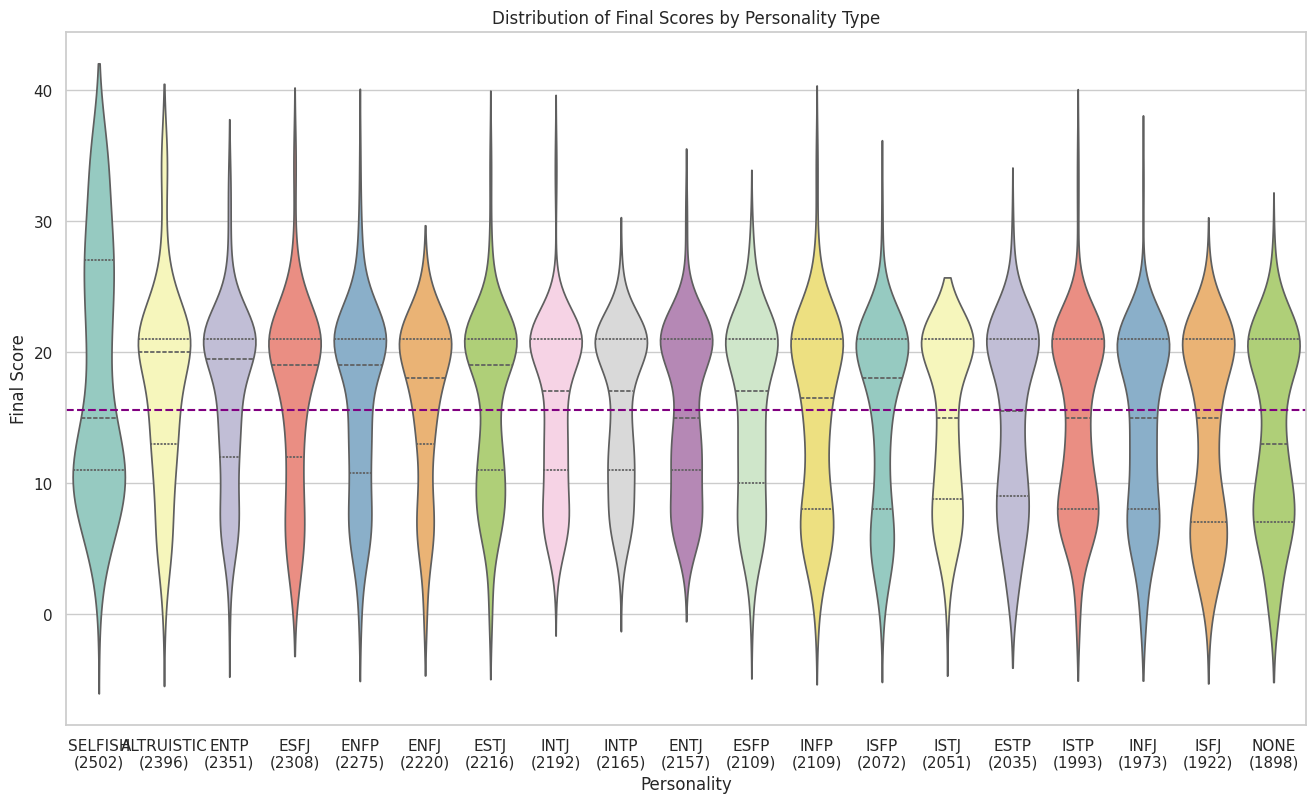

In [23]:
# Extract the final scores and personality types
final_scores = []
for i, row in df.iterrows():
    final_scores.append({'Personality': row['personality_1'], 'Final Score': row['agent_1_cumulative_scores'][-1]})
    final_scores.append({'Personality': row['personality_2'], 'Final Score': row['agent_2_cumulative_scores'][-1]})

# Create a DataFrame from the final scores
final_scores_df = pd.DataFrame(final_scores)
mean_final_score = final_scores_df['Final Score'].mean()

# Calculate total scores across all games for each personality
total_scores = final_scores_df.groupby('Personality')['Final Score'].sum().reset_index()
total_scores = total_scores.sort_values(by='Final Score', ascending=False)
total_scores_dict = total_scores.set_index('Personality')['Final Score'].to_dict()

# Sort final_scores_df by the total scores
final_scores_df['Total Score'] = final_scores_df['Personality'].map(total_scores_dict)
final_scores_df = final_scores_df.sort_values(by='Total Score', ascending=False).drop(columns=['Total Score'])

# Plot the distribution of final scores by personality type using box plot
plt.figure(figsize=(16, 9))
sns.boxplot(data=final_scores_df, x='Personality', y='Final Score')
plt.axhline(y=mean_final_score, color='purple', linestyle='--', label=f'Mean Final Score: {mean_final_score:.2f}')
plt.legend()
plt.title('Distribution of Final Scores by Personality Type')

# Add total scores as x-tick labels
xticks_labels = [f"{personality}\n({total_scores_dict[personality]})" for personality in final_scores_df['Personality'].unique()]
plt.xticks(ticks=range(len(xticks_labels)), labels=xticks_labels)

plt.xlabel('Personality')
plt.ylabel('Final Score')
#save_plot using the name of the games and the run_ids
#plt.savefig(f"final_scores_boxplot_{
plt.show()

# Plot the distribution of final scores by personality type using violin plot
plt.figure(figsize=(16, 9))
sns.violinplot(data=final_scores_df, x='Personality', y='Final Score', inner='quartile', palette='Set3')
plt.title('Distribution of Final Scores by Personality Type')

# Add total scores as x-tick labels
xticks_labels = [f"{personality}\n({total_scores_dict[personality]})" for personality in final_scores_df['Personality'].unique()]
plt.xticks(ticks=range(len(xticks_labels)), labels=xticks_labels)

plt.axhline(y=mean_final_score, color='purple', linestyle='--', label=f'Mean Final Score: {mean_final_score:.2f}')

plt.xlabel('Personality')
plt.ylabel('Final Score')
plt.show()

## plot mean cummulative scores
some scores that start of strong, end up worse than others: guessing because agents don t tolerate repeated lying and then just defect each round as well.
Maybe with a alonger game, the difference would be even more clear.

# truthfulness
- the altruitic is not much higher, because sometimes the other agent says it will defect and it defects. while the altruistic then wants to stick to the positive message but still mirrors the others aciton,
- this could be explained by different reasons: the prompt is way shorter, so it s not as strong/easy to follow for the agent
- maybe rename to honest

In [24]:
import pandas as pd
import ast

# Build the per-agent truthfulness list
truthfulness_data = []

for i, row in df.iterrows():
    for personality, truthfulness in zip([row['personality_1'], row['personality_2']], [row['truthful_agent_1'], row['truthful_agent_2']]):
        try:
            truthfulness_list = ast.literal_eval(truthfulness) if isinstance(truthfulness, str) else truthfulness
            truthfulness_bool = [bool(t) for t in truthfulness_list]
            truthfulness_data.append({
                'Personality': personality,
                'Truthful': sum(truthfulness_bool),
                'Total': len(truthfulness_bool)
            })
        except (ValueError, SyntaxError):
            print(f"Skipping row {i} due to malformed data: {truthfulness}")

# Keep raw data per instance
truthfulness_df = pd.DataFrame(truthfulness_data)
truthfulness_df['Truthfulness Percentage'] = truthfulness_df['Truthful'] / truthfulness_df['Total'] * 100


/tmp/ipykernel_2228954/3826219013.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=truthfulness_df, x='Personality', y='Truthfulness Percentage', palette='Set2', ci=95)
/tmp/ipykernel_2228954/3826219013.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=truthfulness_df, x='Personality', y='Truthfulness Percentage', palette='Set2', ci=95)


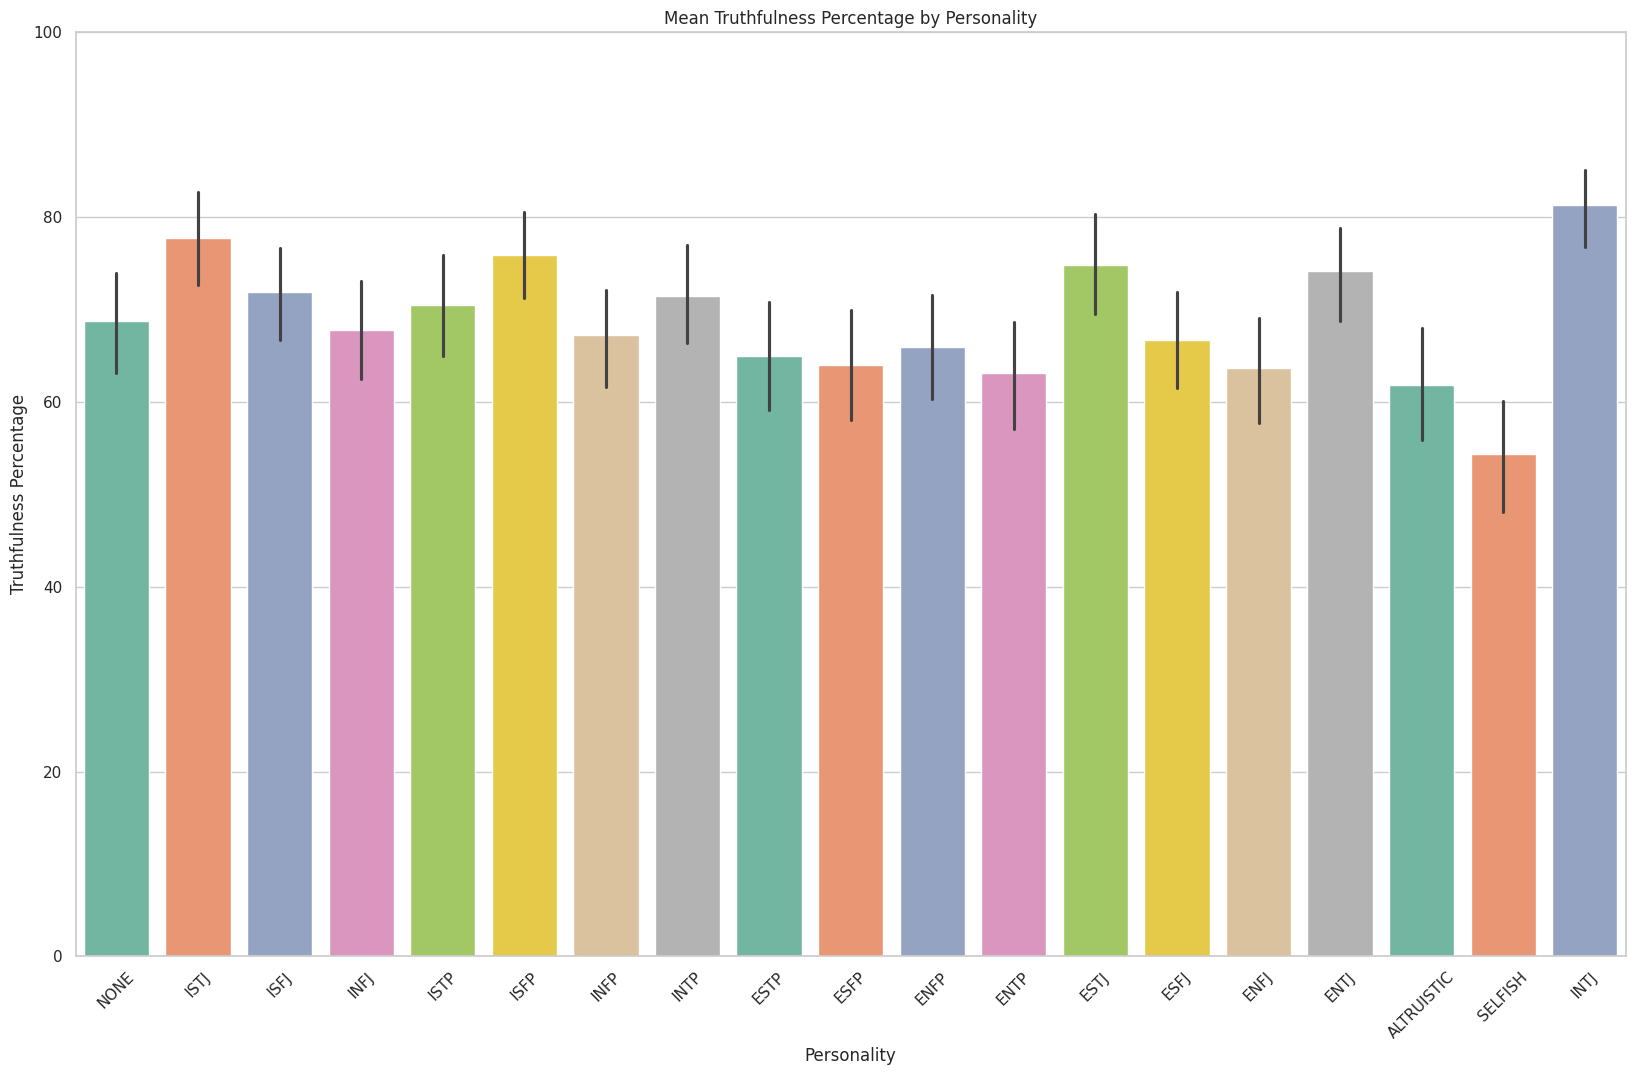

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 12))

# Plot mean truthfulness with 95% confidence intervals (default in seaborn)
sns.barplot(data=truthfulness_df, x='Personality', y='Truthfulness Percentage', palette='Set2', ci=95)

plt.title('Mean Truthfulness Percentage by Personality')
plt.xlabel('Personality')
plt.ylabel('Truthfulness Percentage')
plt.xticks(rotation=45)
plt.ylim(0, 100)  # assuming percentages are between 0–100

# Save and show
plt.savefig(os.path.join(plots_dir, 'mean_truthfulness_percentage_by_personality.png'), bbox_inches='tight')
plt.show()


/tmp/ipykernel_2228954/3349353955.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=filtered_df, x='I/E', y='Truthfulness Percentage', inner='quartile', palette='Set2')
/tmp/ipykernel_2228954/3349353955.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=filtered_df, x='N/S', y='Truthfulness Percentage', inner='quartile', palette='Set2')
/tmp/ipykernel_2228954/3349353955.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=filtered_df, x='T/F', y='Truthfulness Percentage', inner='quartile', palette='Set2')
/tmp/ip

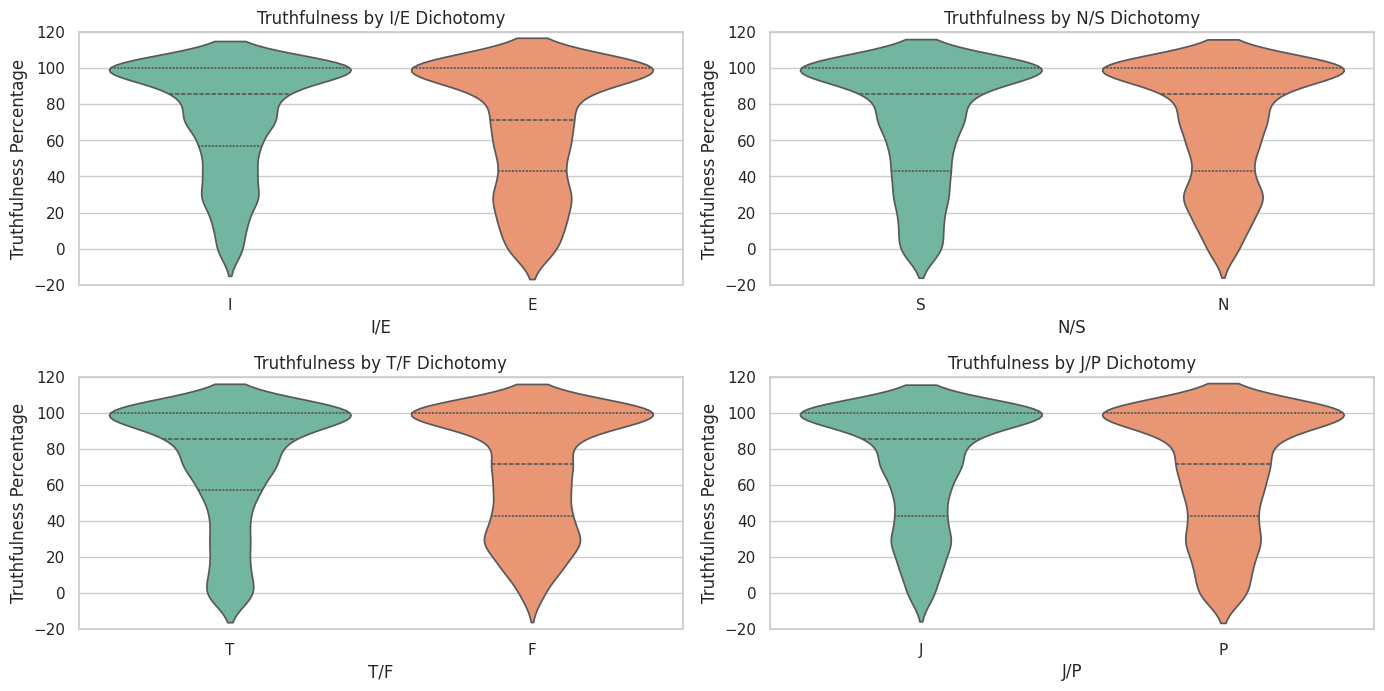

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out control groups from the raw data
filtered_df = truthfulness_df[~truthfulness_df['Personality'].isin(['NONE', 'ALTRUISTIC', 'SELFISH'])].copy()

# Create new columns for each dichotomy based on personality letters
filtered_df['I/E'] = filtered_df['Personality'].apply(lambda x: 'I' if x[0] == 'I' else 'E')
filtered_df['N/S'] = filtered_df['Personality'].apply(lambda x: 'N' if x[1] == 'N' else 'S')
filtered_df['T/F'] = filtered_df['Personality'].apply(lambda x: 'T' if x[2] == 'T' else 'F')
filtered_df['J/P'] = filtered_df['Personality'].apply(lambda x: 'J' if x[3] == 'J' else 'P')

# Set consistent Y-axis range
y_min, y_max = -20, 120

# Plot
plt.figure(figsize=(14, 10))

plt.subplot(3, 2, 1)
sns.violinplot(data=filtered_df, x='I/E', y='Truthfulness Percentage', inner='quartile', palette='Set2')
plt.title('Truthfulness by I/E Dichotomy')
plt.ylim(y_min, y_max)

plt.subplot(3, 2, 2)
sns.violinplot(data=filtered_df, x='N/S', y='Truthfulness Percentage', inner='quartile', palette='Set2')
plt.title('Truthfulness by N/S Dichotomy')
plt.ylim(y_min, y_max)

plt.subplot(3, 2, 3)
sns.violinplot(data=filtered_df, x='T/F', y='Truthfulness Percentage', inner='quartile', palette='Set2')
plt.title('Truthfulness by T/F Dichotomy')
plt.ylim(y_min, y_max)

plt.subplot(3, 2, 4)
sns.violinplot(data=filtered_df, x='J/P', y='Truthfulness Percentage', inner='quartile', palette='Set2')
plt.title('Truthfulness by J/P Dichotomy')
plt.ylim(y_min, y_max)

# Optional: Save the figure
# plt.savefig(os.path.join(plots_dir, 'truthfulness_percentage_by_dichotomy_corrected.png'), bbox_inches='tight')

plt.tight_layout()
plt.savefig(plots_dir + "truthfullness_violin_per_dichotomy.png")
plt.show()


/tmp/ipykernel_2228954/957746663.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=filtered_df, x=title, y='Truthfulness Percentage', inner='quartile', palette='Set2')
/tmp/ipykernel_2228954/957746663.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=filtered_df, x=title, y='Truthfulness Percentage', inner='quartile', palette='Set2')
/tmp/ipykernel_2228954/957746663.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=filtered_df, x=title, y='Truthfulness Percentage', inner='quartile', palette='Set2')
/tmp/ipyke

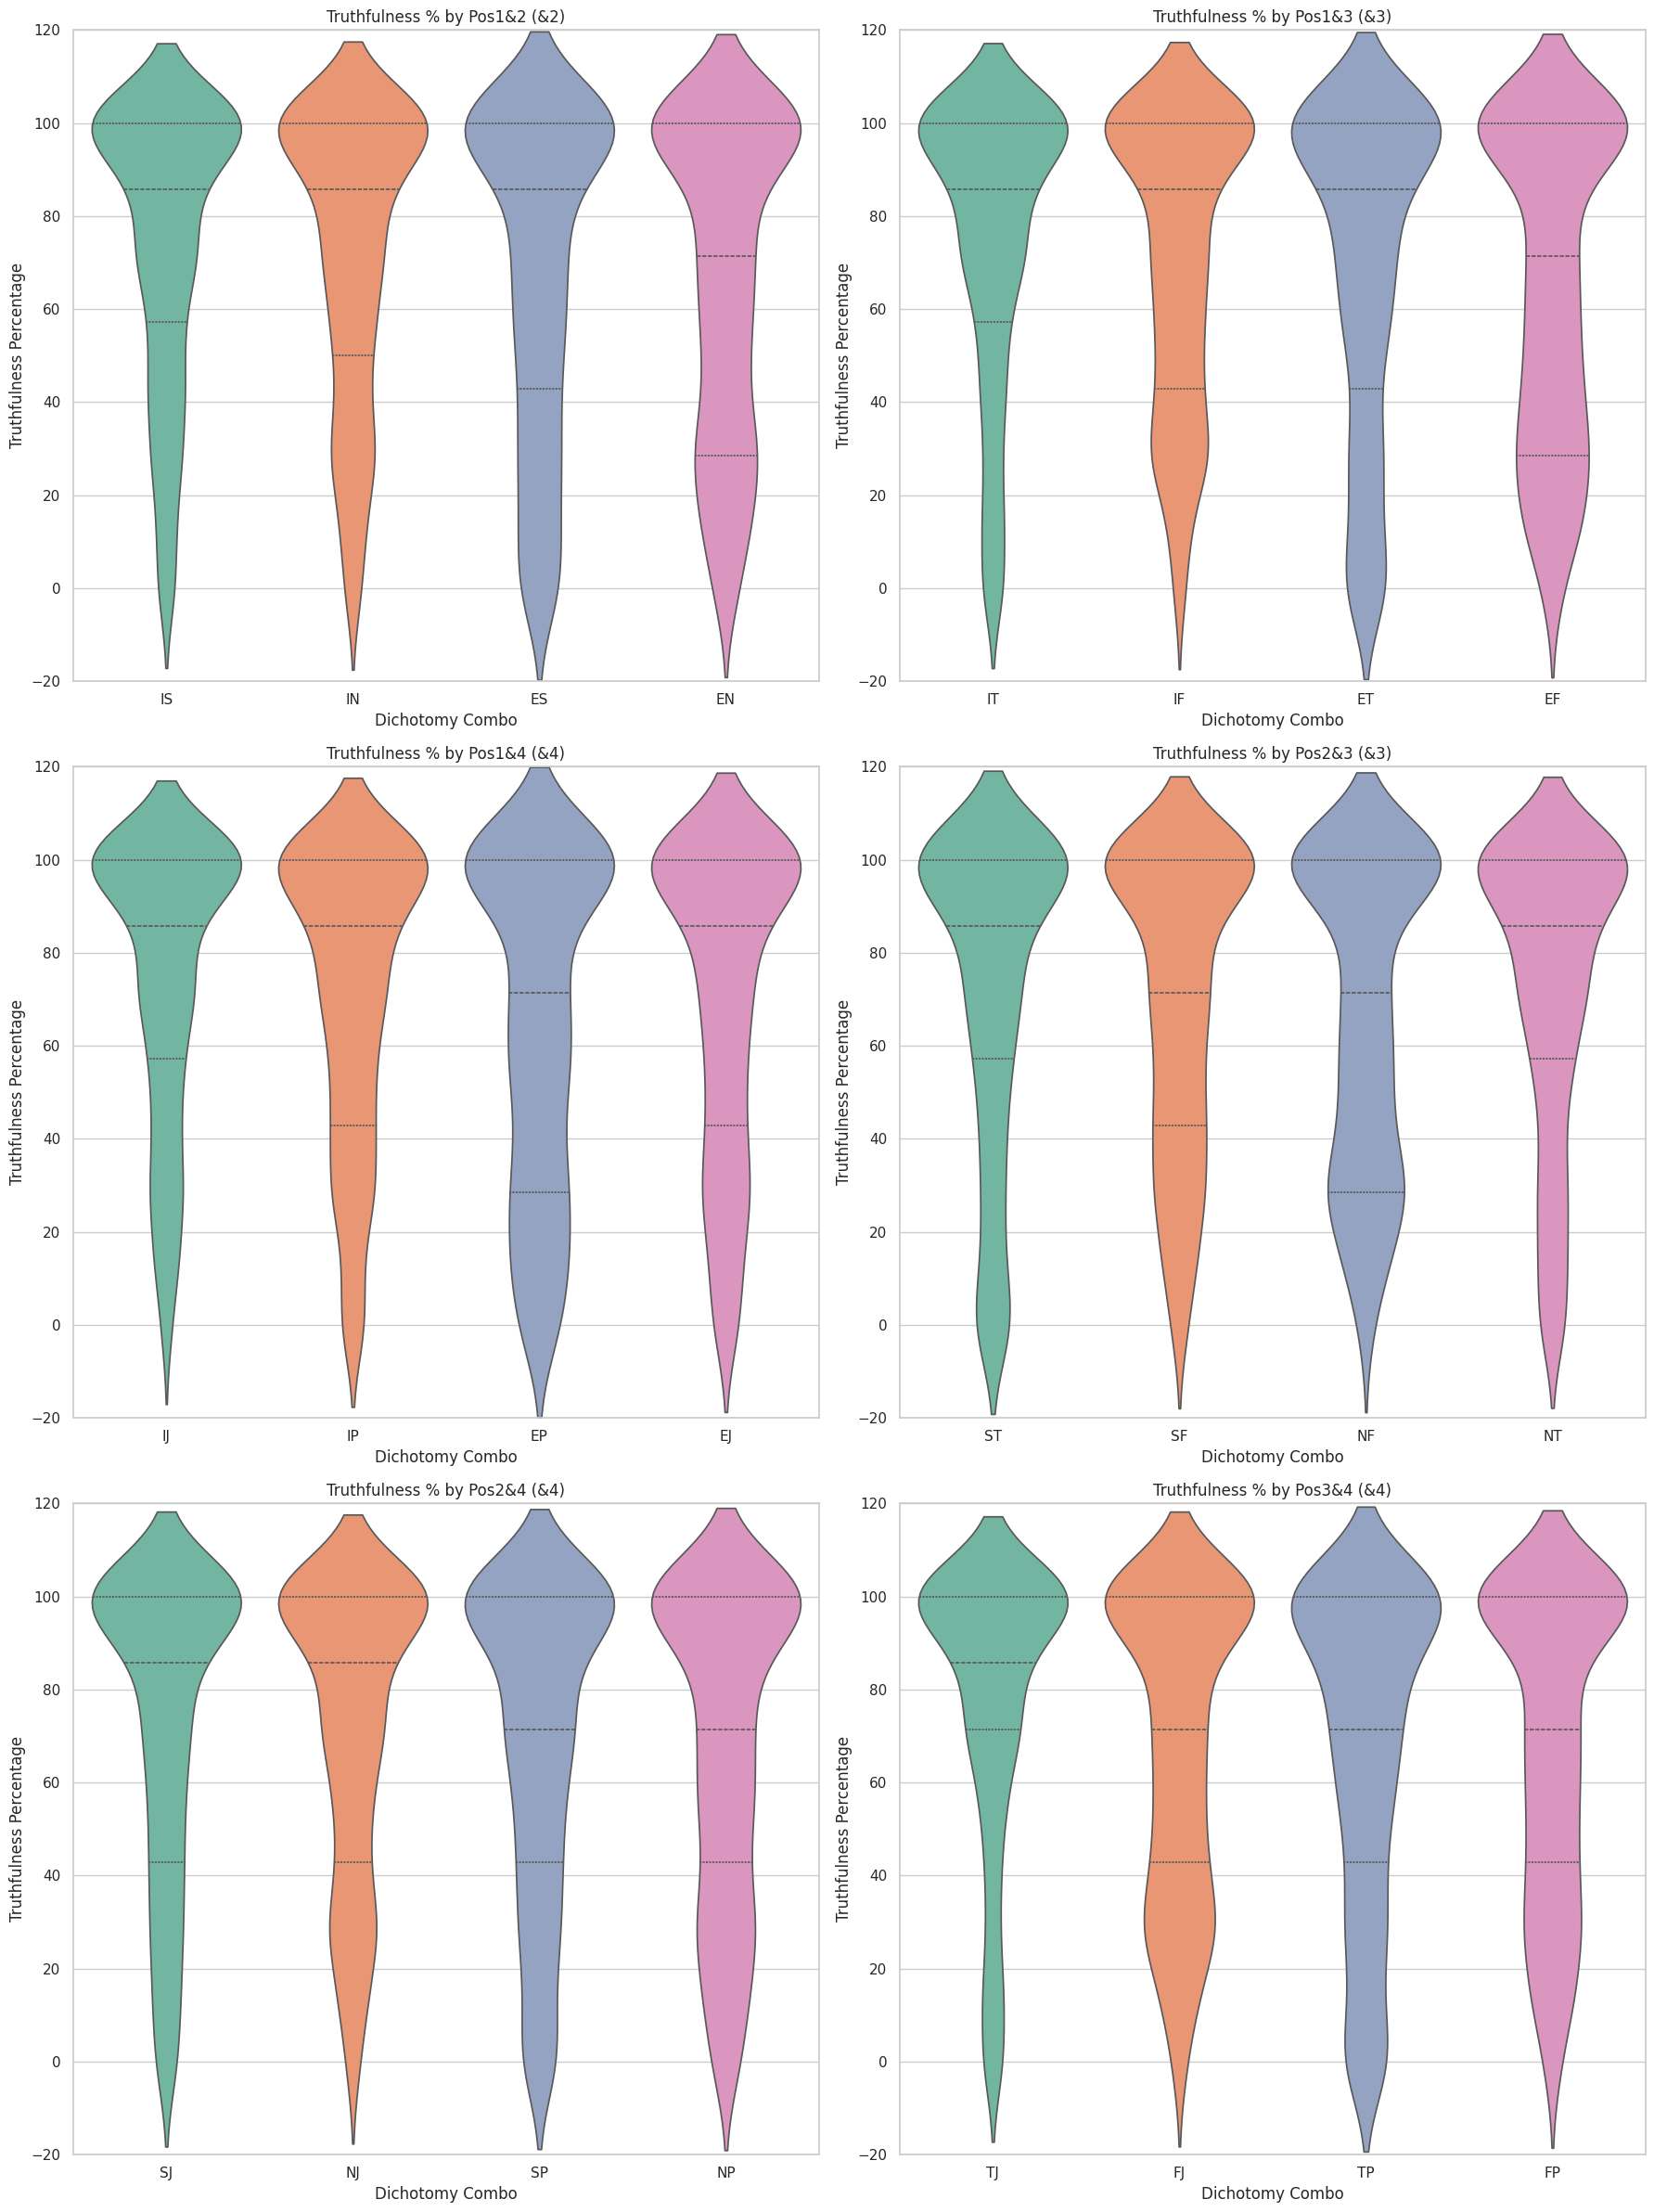

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define all 2-letter dichotomy position combos
position_pairs = {
    'Pos1&2': (0, 1),  # E/I + S/N
    'Pos1&3': (0, 2),  # E/I + T/F
    'Pos1&4': (0, 3),  # E/I + J/P
    'Pos2&3': (1, 2),  # S/N + T/F
    'Pos2&4': (1, 3),  # S/N + J/P
    'Pos3&4': (2, 3),  # T/F + J/P
}

# Estimate global y-axis scale
y_min = -20
y_max = 120

plt.figure(figsize=(18, 24))

for i, (title, (pos1, pos2)) in enumerate(position_pairs.items(), 1):
    # Create new column for the dichotomy combination
    filtered_df[title] = filtered_df['Personality'].apply(lambda x: x[pos1] + x[pos2])

    # Plot without p-values
    plt.subplot(3, 2, i)
    sns.violinplot(data=filtered_df, x=title, y='Truthfulness Percentage', inner='quartile', palette='Set2')
    plt.title(f'Truthfulness % by {title} ({title[-2:]})')
    plt.xlabel('Dichotomy Combo')
    plt.ylim(y_min, y_max)

plt.tight_layout()
plt.savefig(plots_dir + "truthfullness_violin_per_dichotomy_combined.png")
plt.show()


Personality: NONE, Mean Cumulative Scores: [0.0, 2.553956834532374, 4.820143884892087, 6.748201438848921, 8.553956834532373, 10.287769784172662, 11.964028776978417, 13.654676258992806]
Personality: ISTJ, Mean Cumulative Scores: [0.0, 2.7357142857142858, 5.0, 6.992857142857143, 9.007142857142858, 10.9, 12.735714285714286, 14.65]
Personality: ISFJ, Mean Cumulative Scores: [0.0, 2.3285714285714287, 4.378571428571429, 6.292857142857143, 8.228571428571428, 10.114285714285714, 11.885714285714286, 13.728571428571428]
Personality: INFJ, Mean Cumulative Scores: [0.0, 2.4855072463768115, 4.557971014492754, 6.731884057971015, 8.753623188405797, 10.572463768115941, 12.405797101449275, 14.297101449275363]
Personality: ISTP, Mean Cumulative Scores: [0.0, 2.7445255474452557, 5.043795620437956, 6.978102189781022, 8.86861313868613, 10.832116788321168, 12.693430656934307, 14.547445255474452]
Personality: ISFP, Mean Cumulative Scores: [0.0, 2.4779411764705883, 4.867647058823529, 7.044117647058823, 9.1323

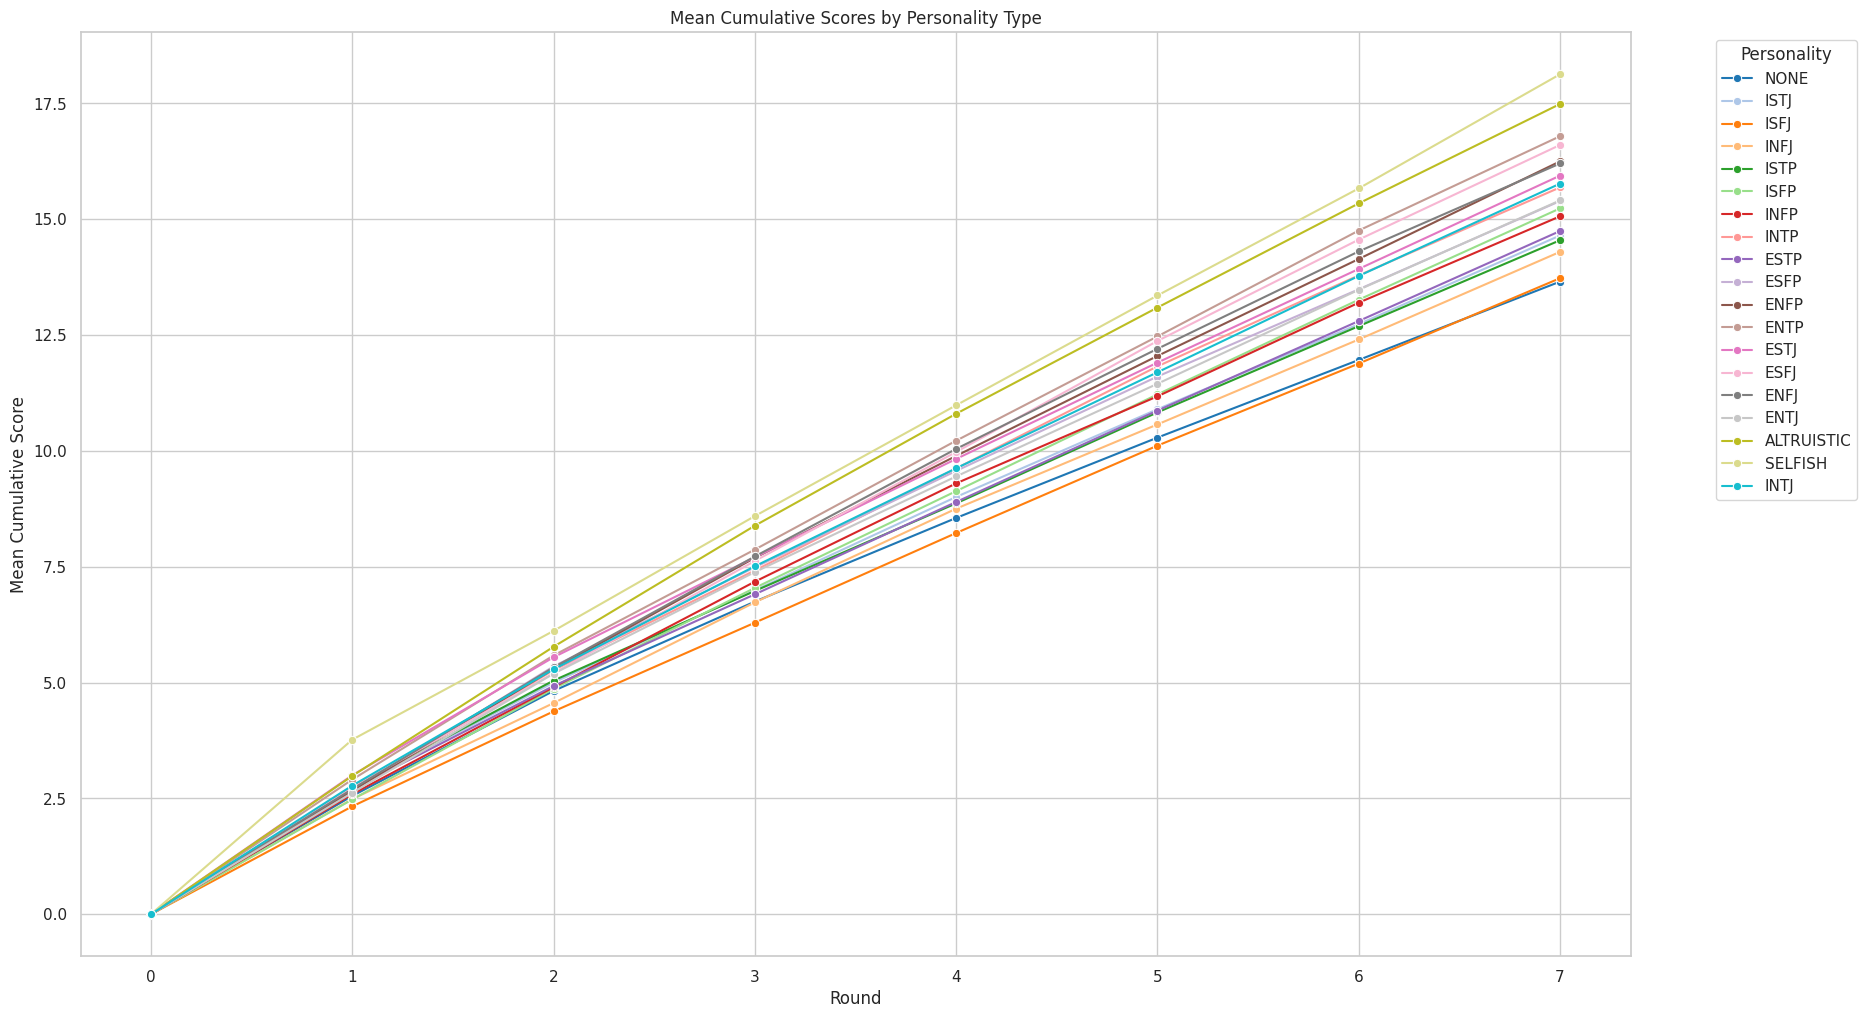

In [28]:

from collections import defaultdict

# Initialize a dictionary to store cumulative scores by personality
cumulative_scores_by_personality = defaultdict(list)

# Iterate through the dataframe and collect cumulative scores
for i, row in df.iterrows():
    for personality, scores in zip([row['personality_1'], row['personality_2']], [row['agent_1_cumulative_scores'], row['agent_2_cumulative_scores']]):
        cumulative_scores_by_personality[personality].append(scores)

# Calculate the mean cumulative scores for each personality
mean_cumulative_scores_by_personality = {}
for personality, scores_list in cumulative_scores_by_personality.items():
    # Transpose the list of scores to calculate the mean for each roundviridis
    transposed_scores = list(zip(*scores_list))
    mean_cumulative_scores = [sum(scores) / len(scores) for scores in transposed_scores]
    mean_cumulative_scores_by_personality[personality] = mean_cumulative_scores

# Print the mean cumulative scores for each personality
for personality, mean_scores in mean_cumulative_scores_by_personality.items():
    print(f"Personality: {personality}, Mean Cumulative Scores: {mean_scores}")
    
    # Create a DataFrame for plotting
    plot_data = []
    for personality, mean_scores in mean_cumulative_scores_by_personality.items():
        for round_num, score in enumerate(mean_scores):
            plot_data.append({'Personality': personality, 'Round': round_num, 'Mean Cumulative Score': score})

plot_df = pd.DataFrame(plot_data)

# Plot the mean cumulative scores for each personality
plt.figure(figsize=(20, 12))
sns.lineplot(data=plot_df, x='Round', y='Mean Cumulative Score', hue='Personality', palette='tab20', marker='o')
plt.title('Mean Cumulative Scores by Personality Type')
plt.xlabel('Round')
plt.ylabel('Mean Cumulative Score')
plt.legend(title='Personality', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.savefig(f"{plots_dir}mean_cumulative_scores.png", dpi=300, bbox_inches='tight')
plt.show()

In [29]:
# Group the data by model_name_1 instead of game_name
df_TF = pd.DataFrame(columns=["model_name_1", "T/F", "strategy_switches"])
df_TF = df[['model_name_1', 'T/F_1', 'strategy_switches_agent_1']].rename(columns={'T/F_1': 'T/F', 'strategy_switches_agent_1': 'strategy_switches'})
df_TF_2 = df[['model_name_1', 'T/F_2', 'strategy_switches_agent_2']].rename(columns={'T/F_2': 'T/F', 'strategy_switches_agent_2': 'strategy_switches'})
df_TF = pd.concat([df_TF, df_TF_2], ignore_index=True)
df_TF = df_TF[df_TF['T/F'].notna()]

# Create a separate plot for each model_name_1
unique_models = df_TF['model_name_1'].unique()

# Create subplots for each model
num_models = len(unique_models)
#fig, axes = plt.subplots(num_models, 1, figsize=(10, 6 * num_models))
#
#for ax, model in zip(axes, unique_models):
#    sns.violinplot(data=df_TF[df_TF['model_name_1'] == model], x='T/F', y='strategy_switches', palette='muted', ax=ax)
#    ax.set_title(f'Strategy Switches by T/F Personality for {model}')
#    ax.set_xlabel('T/F Personality')
#    ax.set_ylabel('Strategy Switches')
#
#plt.tight_layout()
#plt.savefig(os.path.join(plots_dir, 'strategy_switches_by_model.png'))
#plt.show()


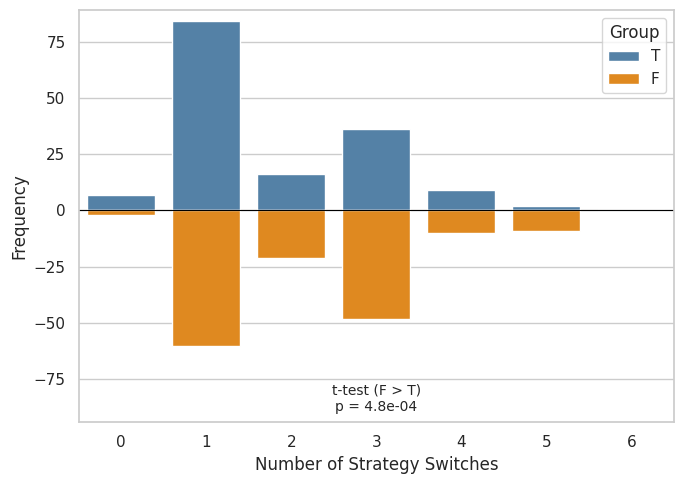

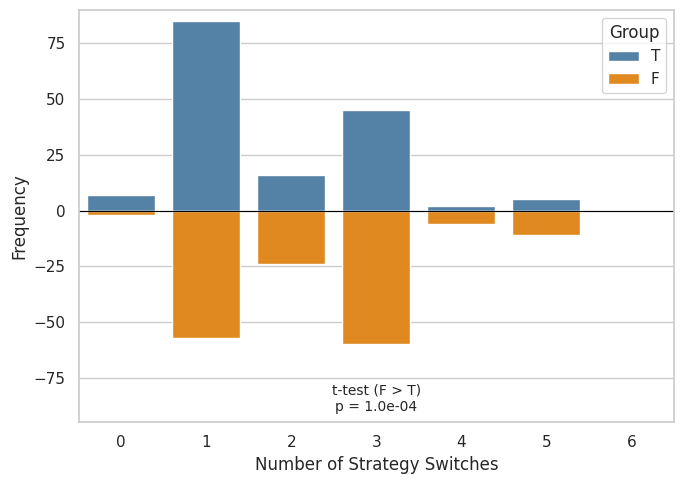

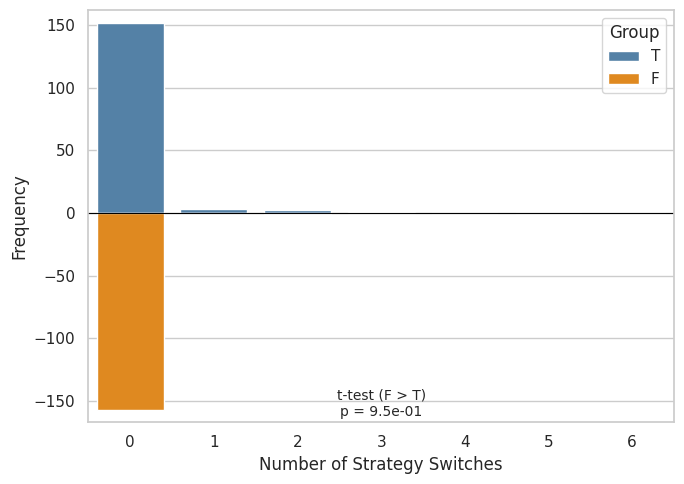

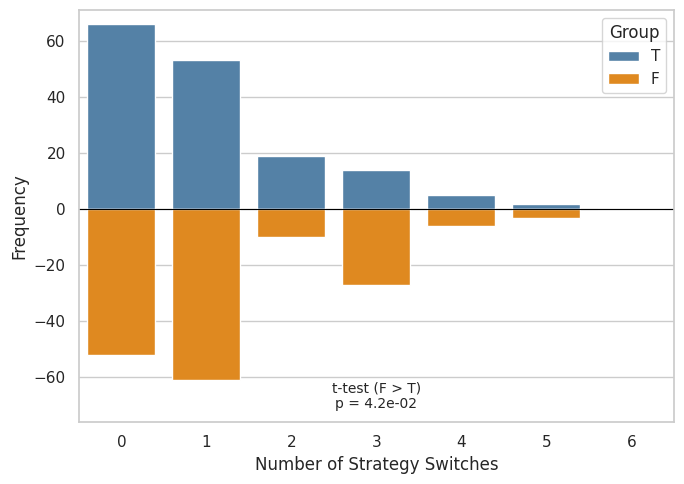

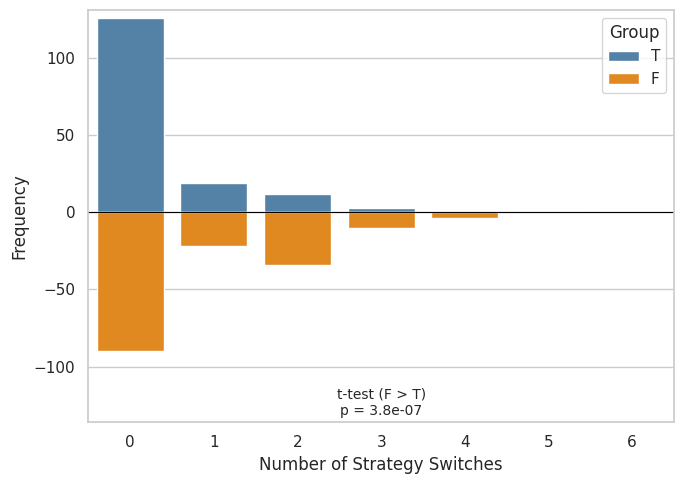

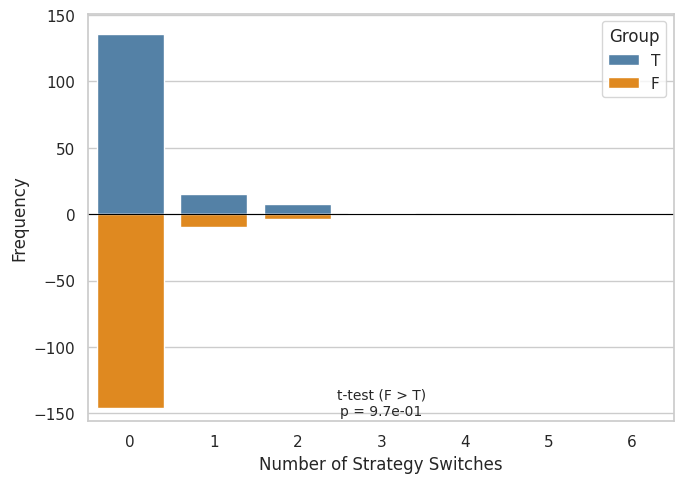

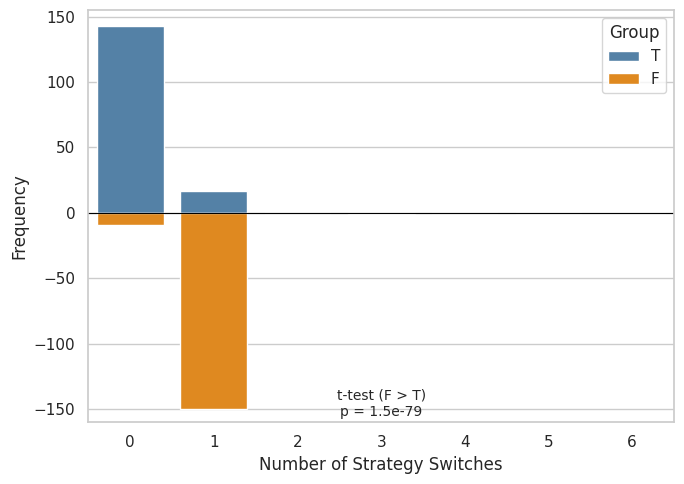

In [30]:
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Iterate through each model and create a separate plot
for model in unique_models:
    model_data = df_TF[df_TF['model_name_1'] == model]
    
    # T group
    t_data = model_data[model_data['T/F'] == 'T']['strategy_switches'].value_counts().reindex(range(7), fill_value=0)
    t_switches = model_data[model_data['T/F'] == 'T']['strategy_switches']
    
    # F group
    f_data = model_data[model_data['T/F'] == 'F']['strategy_switches'].value_counts().reindex(range(7), fill_value=0)
    f_switches = model_data[model_data['T/F'] == 'F']['strategy_switches']

    # Create a new figure for each model
    plt.figure(figsize=(7, 5))
    
    # Plot T (upward bars)
    sns.barplot(x=t_data.index, y=t_data.values, color='steelblue', label='T')

    # Plot F (downward bars)
    sns.barplot(x=f_data.index, y=-f_data.values, color='darkorange', label='F')

    # Run t-test (F > T)
    if len(t_switches) > 1 and len(f_switches) > 1:
        try:
            stat, p_value = ttest_ind(f_switches, t_switches, alternative='greater', equal_var=False)
            p_sci = f"{p_value:.1e}"
            p_text = f"t-test (F > T)\np = {p_sci}"
        except Exception as e:
            p_text = f"Test failed:\n{e}"
    else:
        p_text = "Not enough data"

    # Annotate p-value
    max_y = max(t_data.values.max(), f_data.values.max())
    plt.ylim(-max_y - 10, max_y + 5)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.text(3, -max_y - 5, p_text, ha='center', fontsize=10)

    # Labels and title
    plt.xlabel('Number of Strategy Switches')
    plt.ylabel('Frequency')
    plt.legend(title='Group')

    # Save the plot
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, f'strategy_switches_{model}.png'))
    plt.show()
    plt.close()


# who lied first
- often, the agent stop being truthful because they keep getting lied to
- which is why i caught some pointers to show if the agent lied first in each conversation.
- we ignore the cases when the other agent defects first, even if they are being truthful about the fact theat they will defect.
- to explain why it looks like altruistic would lie ,first, but it s just a consequence of the other saying they will defect explictly.

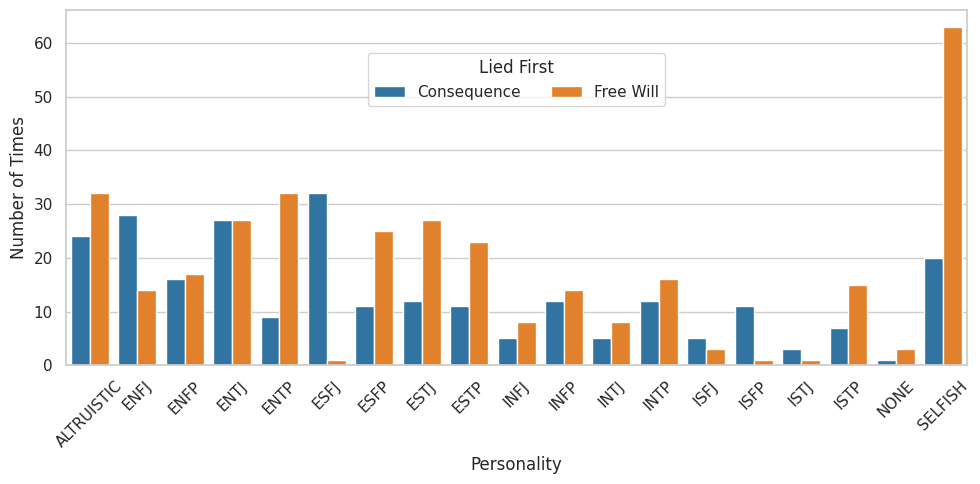

/tmp/ipykernel_2228954/3311568.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data_times_mbti['I/E'] = plot_data_times_mbti['Personality'].apply(


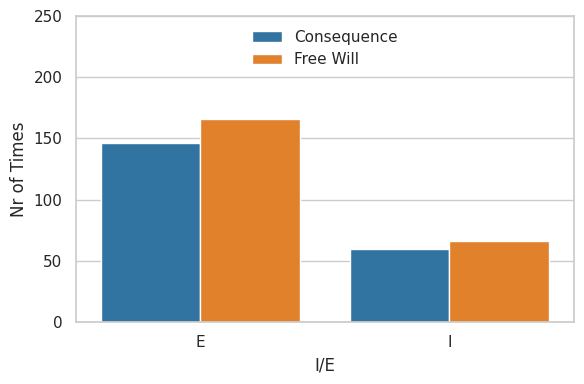

In [34]:
import seaborn as sns

df['lied_first_1'] = [False] * len(df)
df['lied_first_2'] = [False] * len(df)
df['defected_first_1'] = [False] * len(df)
df['defected_first_2'] = [False] * len(df)

for i, row in df.iterrows():
    personality_1 = row['personality_1']
    personality_2 = row['personality_2']
    
    for truthful_1, truthful_2, intent_1, intent_2 in zip(row['truthful_agent_1'], row['truthful_agent_2'], row['intent_agent_1'], row['intent_agent_2']):
        if (truthful_1 == False) and (truthful_2 == True):
            df.at[i, 'lied_first_1'] = True
            break
        elif (truthful_1 == True) and (truthful_2 == False):
            df.at[i, 'lied_first_2'] = True
            break
    for action_1, action_2 in zip(row['agent_1_actions'], row['agent_2_actions']):
        if (action_1 == 'defect') and (action_2 == 'cooperate'):
            
            df.at[i, 'defected_first_1'] = True
            break
        elif (action_1 == 'cooperate') and (action_2 == 'defect'):
            df.at[i, 'defected_first_2'] = True
            break
        elif (action_1 == 'defect') and (action_2 == 'defect'):
            if (intent_1 == 'defect') and (intent_2 == 'cooperate'):
                df.at[i, 'defected_first_2'] = True
                break
            elif (intent_1 == 'cooperate') and (intent_2 == 'defect'):
                df.at[i, 'defected_first_1'] = True
                break
#calculate nrs of times
# Calculate the nr of times each personality lied first
first_liars = df.groupby('personality_1')['lied_first_1'].sum().to_dict()
first_liars.update(df.groupby('personality_2')['lied_first_2'].sum().to_dict())

# Calculate the number of times each personality lied first and whether it was a consequence of being defected first
first_liars_consequence = df.groupby('personality_1')['defected_first_2'].sum().to_dict()
first_liars_consequence.update(df.groupby('personality_2')['defected_first_1'].sum().to_dict())

# Calculate the number of times each personality lied first without being defected first
first_liars_no_consequence = {k: abs(first_liars[k] - first_liars_consequence.get(k, 0)) for k in first_liars.keys()}

# Create a DataFrame for plotting (shortened column names)
plot_data_times = pd.DataFrame({
    'Personality': list(first_liars.keys()),
    'Consequence': list(first_liars_consequence.values()),
    'Free Will': list(first_liars_no_consequence.values())
})

# Plot the number of times
plt.figure(figsize=(10, 5))
sns.barplot(data=plot_data_times.melt(id_vars="Personality", var_name="Type", value_name="Count"),
            x="Personality", y="Count", hue="Type", palette=['#1f77b4', '#ff7f0e'])
#plt.title('Number of Times Each Personality Lied First (Consequence vs Free Will)')
plt.xlabel('Personality')
plt.ylabel('Number of Times')
plt.legend(title='Lied First', loc='upper center', bbox_to_anchor=(0.5, 0.9), ncol=2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'lied_first_count.png'))
plt.show()

# max amount of first lies by dichotomy
max_lies = len(df) / 2

# Split MBTI and non-MBTI
plot_data_times_non_mbti = plot_data_times[plot_data_times['Personality'].isin(nonmbti)]
plot_data_times_mbti = plot_data_times[~plot_data_times['Personality'].isin(nonmbti)]

# Add I/E labels
plot_data_times_mbti['I/E'] = plot_data_times_mbti['Personality'].apply(
    lambda x: 'I' if x[0] == 'I' else 'E' if x not in nonmbti else None
)

# Combine MBTI and non-MBTI (for completeness)
plot_data_times = pd.concat([plot_data_times_mbti, plot_data_times_non_mbti], ignore_index=True)

# Group by I/E
plot_data_times_IE = plot_data_times[["I/E", "Consequence", "Free Will"]].groupby("I/E").sum().reset_index()
# Infer total appearances of I and E personalities
total_I = sum(df['personality_1'].str.startswith('I')) + sum(df['personality_2'].str.startswith('I'))
total_E = sum(df['personality_1'].str.startswith('E')) + sum(df['personality_2'].str.startswith('E'))

# Get counts
free_will_I = plot_data_times_IE[plot_data_times_IE["I/E"] == "I"]["Free Will"].values[0]
free_will_E = plot_data_times_IE[plot_data_times_IE["I/E"] == "E"]["Free Will"].values[0]
conseq_I = plot_data_times_IE[plot_data_times_IE["I/E"] == "I"]["Consequence"].values[0]
conseq_E = plot_data_times_IE[plot_data_times_IE["I/E"] == "E"]["Consequence"].values[0]

# Contingency tables
free_will_table = [[free_will_E, total_E - free_will_E],
                   [free_will_I, total_I - free_will_I]]
conseq_table = [[conseq_E, total_E - conseq_E],
                [conseq_I, total_I - conseq_I]]

# Fisher’s tests
try:
    _, p_fw = fisher_exact(free_will_table, alternative='greater')
    _, p_con = fisher_exact(conseq_table, alternative='greater')
    p_fw_text = f"p = {p_fw:.2e}"
    p_con_text = f"p = {p_con:.2e}"
except Exception as e:
    p_fw_text = f"Free Will test failed: {e}"
    p_con_text = f"Consequence test failed: {e}"
    

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.ylim(0, 250)

# Create the barplot
bar = sns.barplot(
    data=plot_data_times_IE.melt(id_vars="I/E", var_name="Type", value_name="Count"), 
    x="I/E", y="Count", hue="Type", palette=['#1f77b4', '#ff7f0e']
)

#plt.title('Nr of Times Each Personality Lied First (Consequence of Defection Threat vs Free Will) by I/E')

# Get the handles and labels from the current legend
handles, _ = bar.get_legend_handles_labels()

# Replace legend with updated labels
plt.legend(handles=handles, title='', loc='upper center', frameon=False)

plt.xlabel('I/E')
plt.ylabel('Nr of Times')
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'lied_first_by_IE.png'), bbox_inches='tight')
plt.show()


 